## Final Project: Lucinda Sisk

**Question of interest**

Can we predict threat and safety task conditions using FCMA? Fear learning has been heavily studied, yet less is known about the neural underpinnings of safety learning, and to what extent fear and safety representations are distinct from each other. If we are able to predict condition based on neural data, that would proviide some evidence that these representations are distinct, and lay the groundwork for future examinations of what regions are involved and how such representations may differ as function of factors such as age and exposure to trauma. 

**Dataset information**

* Data: Data are the first "testing" run of the Shapes task, collected in Dr. Dylan Gee's lab.
* Participants: Participants are 5 adults who completed the Shapes task.
* Preprocessing: Data were preprocessed using the HCP Minimal Processing pipeline (Glasser et al., 2013; Meyer & Odriozola, 2020)

**Step 1:** Read in packages and set variables

In [1]:
# Import packages
import numpy as np
import pandas as pd
from glob import glob
import nibabel as nib
from nilearn import plotting, image
import os
import copy
import matplotlib.pyplot as plt
from brainiak import io
from brainiak.utils.fmrisim import _double_gamma_hrf as hrf_func
from brainiak.utils import fmrisim as sim
from brainiak.utils.fmrisim import export_epoch_file
from brainiak.fcma.preprocessing import prepare_fcma_data
from brainiak.fcma.util import compute_correlation

In [2]:
# Set paths and variables
home = '/gpfs/milgram/pi/gee_dylan/candlab/data'
hcpdata = home + '/mri/hcp_pipeline_preproc/shapes'
taskfiles = home + '/behavioral/shapes/task_design_trialwise'
finaldata = '/gpfs/milgram/scratch60/gee_dylan/lms233/cmhn2021/cmhn-s21-finalproject/image_data'
suffix = 'bold_8dv_resampled.nii.gz'

subs = glob(hcpdata + '/sub-*')
all_sublist = pd.Series(subs).str.split('/', expand = True)[10]
tr_length = 2.5 # From HM PO paper; TR=2500m

In [3]:
def resample_data(subject, new_pixdim):
    #Function to resample functional data to specified dimensions (reduce computational cost)
    file = nib.load(hcpdata + '/{}/MNINonLinear/Results/ses-shapesV1_task-shapes1_bold/ses-shapesV1_task-shapes1_bold_8dv.nii.gz'.format(sub))
    current_affine = file.affine
    current_dim = file.affine[1,1]
    new_affine = copy.deepcopy(current_affine)
    new_affine = np.where(current_affine==current_dim, new_pixdim, new_affine) 
    new_affine = np.where(new_affine==-current_dim, -new_pixdim, new_affine) 

    resampled_file = image.resample_img(img = file,
                                       target_affine = new_affine)
    print(resampled_file.affine)
    
    return resampled_file

In [4]:
# Identify subjects that have data for this task, and select 5 that have data
## Note: Only used 5 subjects as the time cost prohibited me running (and troubleshooting) a larger N
## Note: I upsampled these data to a ridiculously huge voxel size to try to reduce computational time. Of course would not do this in a real analysis!

data_subs = []
for i in range(0, 11): #len(all_sublist)):
    sub = all_sublist[i]
    if os.path.exists(hcpdata + '/{}/MNINonLinear/Results/ses-shapesV1_task-shapes1_bold/ses-shapesV1_task-shapes1_bold_8dv.nii.gz'.format(sub)):
        if os.path.exists(taskfiles + '/{}/Testing1_APLUS_1_8dv.txt'.format(sub.lstrip('sub-'))):
            data_subs.append(sub)
#             resampled_data = resample_data(sub, 5)
#             resampled_data.to_filename(finaldata + '/{}_ses-shapesV1_task-shapes1_bold_8dv_resampled.nii.gz'.format(sub))
        else:
            pass
            #print('Missing data for {}'.format(sub))
print("{} subs have data".format(len(data_subs)))

5 subs have data


In [5]:
# Created this mask file using the copy_data script (uploaded)
mask_file =  os.path.join(finaldata + '/resampled_MNI_mask.nii.gz') # whole brain data

#Load in data
mask = io.load_boolean_mask(mask_file)
images = io.load_images_from_dir(finaldata, suffix)

**Step 2:** Create functions to read in and organize data

In [6]:
def pull_timing_info(testingfiles):
    #This function reads in processed timing files for each subject, splits them into onset and duration and calculates offset.
    testing_timing = []
    for i in range(0, len(testingfiles)):
        file = pd.read_csv(testingfiles[i], sep = '\t', header = None)
        stim = testingfiles[i].split('_')[-3]
        onset = file.iloc[0,0]
        duration = file.iloc[0,1]
        offset = onset + duration
        testing_timing.append([stim, onset, offset, duration])
    timing_file = pd.DataFrame(testing_timing, columns = ['Stimulus', 'Onset', 'Offset', 'Duration']).sort_values(by='Onset')
    assert len(timing_file) > 0
    return timing_file


In [7]:
def shift_labels(timing_data, n_volumes):
    # This function shifts timing labels by 5 seconds to account for hemodynamic lag.
    labels = []
    for i in range(0, n_volumes):
        for j in range(0, len(timing_data)):
            if i == timing_data['Onset_Shifted'][j]:
                if timing_data['Stimulus'][j] == 'AMINUS':
                    labels.append([i, 1])

                elif timing_data['Stimulus'][j] == 'APLUS':
                    labels.append([i, 1])

                elif timing_data['Stimulus'][j] == 'BMINUS':
                    labels.append([i, 2])
                else:
                    pass

            elif i == timing_data['Onset_Shifted'][j] + 1:
                if timing_data['Stimulus'][j] == 'AMINUS':
                    labels.append([i, 1])

                elif timing_data['Stimulus'][j] == 'APLUS':
                    labels.append([i, 1])

                elif timing_data['Stimulus'][j] == 'BMINUS':
                    labels.append([i, 2])
                else:
                    pass

            elif i == timing_data['Onset_Shifted'][j] + 2:
                if timing_data['Stimulus'][j] == 'AMINUS':
                    labels.append([i, 1])

                elif timing_data['Stimulus'][j] == 'APLUS':
                    labels.append([i, 1])

                elif timing_data['Stimulus'][j] == 'BMINUS':
                    labels.append([i, 2])
                else:
                    pass

            elif i == timing_data['Offset_Shifted'][j]:
                if timing_data['Stimulus'][j] == 'AMINUS':
                    labels.append([i, 1])

                elif timing_data['Stimulus'][j] == 'APLUS':
                    labels.append([i, 1])

                elif timing_data['Stimulus'][j] == 'BMINUS':
                    labels.append([i, 2])
                else:
                    pass
            else:
                pass

    empty_df = pd.DataFrame(range(0, n_volumes), columns = ['Volumes'])
    label_s = pd.DataFrame(labels, columns = ['Volumes', 'Stimulus'])

    final_labels = pd.merge(empty_df, label_s, how = 'outer')
    final_labels['Stimulus'] = final_labels['Stimulus'].replace(np.nan, 0)
    out_labels = final_labels['Stimulus'].tolist()

    return out_labels

In [8]:
def create_epoch(n_pres, n_volumes, labels):
    # This function takes in information on number of presentations, volumes and label information, and generates an epoch file.
    final_arr = np.zeros((2, n_pres, n_volumes))
    for i in range(0, len(labels)-1):
        if labels[i] == 0:
            thr_nums = np.zeros((1, int(n_pres)))
            safe_nums = np.pad(np.zeros((int(n_pres/2))), int(n_pres/4))
            pres_arr = np.vstack([thr_nums, safe_nums])
            final_arr[:, :, i] = pres_arr
        elif labels[i] == 1:
            thr_nums = np.ones((1, int(n_pres)))
            safe_nums = np.pad(np.zeros((int(n_pres/2))), int(n_pres/4))
            pres_arr = np.vstack([thr_nums, safe_nums])
            final_arr[:, :, i] = pres_arr
        elif labels[i] == 2:
            thr_nums = np.zeros((1, int(n_pres)))
            safe_nums = np.pad(np.ones((int(n_pres/2))), int(n_pres/4))
            pres_arr = np.vstack([thr_nums, safe_nums])
            final_arr[:, :, i] = pres_arr
    print("Epoch file shape: {}".format(final_arr.shape))
    return final_arr

In [9]:
def extract_data(subject, run):
    # This function takes in a subject and run number, and runs the other functions for each subject and outputs an epoch file
    file = nib.load(finaldata + '/{}_ses-shapesV1_task-shapes1_bold_8dv_resampled.nii.gz'.format(subject))
    file_array = np.array(file.dataobj)
    num_volumes = file.shape[3]
    tr_length = 2.5
    total_time = num_volumes * tr_length
    temp_resolution = 1/tr_length
    print("Loading data for {}".format(subject))

    if run == 1:
        testingfiles = glob(taskfiles + '/{}/Testing1*.txt'.format(subject.lstrip('sub-')))
    elif run ==2:
        testingfiles = glob(taskfiles + '/{}/Testing2*.txt'.format(subject.lstrip('sub-')))
    else:
        print('Error: incorrect run number entered (must be  1 or 2)')

    timing_data = pull_timing_info(testingfiles)
    timing_data['Onset_Shifted'] = np.floor(timing_data['Onset'] + 5.0)
    timing_data['Offset_Shifted'] = np.ceil(timing_data['Onset'] + 5.0)

    threat_df1 = timing_data[timing_data['Stimulus'] == 'AMINUS']
    threat_df2 = timing_data[timing_data['Stimulus'] == 'APLUS']
    threat_df = pd.concat([threat_df1, threat_df2], axis=0)

    safety_df = timing_data[timing_data['Stimulus'] == 'BMINUS']

    labels = shift_labels(timing_data, num_volumes)

    epoch_file = create_epoch(len(threat_df), num_volumes, labels)
   
    return epoch_file, labels
    

**Step 3:** Create and save epoch file list

In [10]:
subs = data_subs

epoch_list = []
for i in range(0, len(subs)-1):
    sub = subs[i]
    epoch, labels = extract_data(sub, 1)
    epoch_list.append(epoch)
    

Loading data for sub-A238
Epoch file shape: (2, 12, 477)
Loading data for sub-A690
Epoch file shape: (2, 12, 477)
Loading data for sub-A218
Epoch file shape: (2, 12, 477)
Loading data for sub-A718
Epoch file shape: (2, 12, 477)


In [11]:
# #Save epoch list
np.save(file = finaldata + '/all_subs_epoch_labels_n{}.npy'.format(len(data_subs)), arr = np.array(epoch_list))
epoch_file = finaldata + '/all_subs_epoch_labels_n5.npy'

In [ ]:
raw_data, _, labels = prepare_fcma_data(images, epoch_list, mask)

**Step 4:** Create commands to create voxel masks, run voxel selection, and run classification.

In [13]:
#Create top voxel masks -- 1500 voxels
print('sbatch make_top_voxel_mask_final.sh {} 1500 {} {}'.format(finaldata, 
                                                        finaldata+ '/fcma_outdata',
                                                                mask_file))

sbatch make_top_voxel_mask_final.sh /gpfs/milgram/scratch60/gee_dylan/lms233/cmhn2021/cmhn-s21-finalproject/image_data 1500 /gpfs/milgram/scratch60/gee_dylan/lms233/cmhn2021/cmhn-s21-finalproject/image_data/fcma_outdata /gpfs/milgram/scratch60/gee_dylan/lms233/cmhn2021/cmhn-s21-finalproject/image_data/resampled_MNI_mask.nii.gz


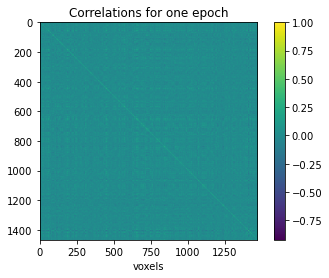

In [41]:
# Extract data for one subject, for one epoch (take only the every 10th voxel)
epoch_data = raw_data[0][:,::10]

# Make the data c contiguous (the type of ordering used in C in which the last dimensions are stored first (opposite of fortran/matlab))
mat = np.ascontiguousarray(epoch_data.T, dtype=np.float32)  # Voxels x TRs for one epoch

# begin_time = time.time()
epoch_corr = compute_correlation(mat, mat)  # correlation of every voxel with every other voxel
# end_time = time.time()
# print("Analysis duration: %0.5fs" % (end_time - begin_time))

plt.figure()
plt.title('Correlations for one epoch');
plt.xlabel('voxels');
plt.imshow(epoch_corr);
plt.colorbar()

Plot top 5000 voxels


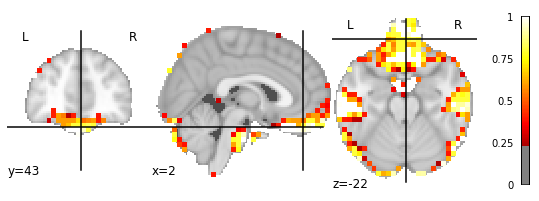

In [39]:
print('Plot top 5000 voxels')

stat_img6 = finaldata + '/fcma_outdata/prop_top5000.nii.gz'

plotting.plot_stat_map(
    stat_img6,
    threshold = 0.24
)

In [16]:
#RUN CV voxel selection
output_dir = finaldata + '/fcma_outdata'
suffix = '8dv_resampled.nii.gz'
# $data_dir $suffix $mask_file $epoch_file $left_out_subj $output_dir

print('Voxel Selection:')
for i in range(0, len(data_subs)):
    outsub = data_subs[i]
    print('sbatch run_fcma_voxel_selection_cv.sh {} {} {} {} {} {}'.format(finaldata, suffix,
                                                                           mask_file, epoch_file, 
                                                                           i, output_dir))
    print('  ')


Voxel Selection:
sbatch run_fcma_voxel_selection_cv.sh /gpfs/milgram/scratch60/gee_dylan/lms233/cmhn2021/cmhn-s21-finalproject/image_data 8dv_resampled.nii.gz /gpfs/milgram/scratch60/gee_dylan/lms233/cmhn2021/cmhn-s21-finalproject/image_data/resampled_MNI_mask.nii.gz /gpfs/milgram/scratch60/gee_dylan/lms233/cmhn2021/cmhn-s21-finalproject/image_data/all_subs_epoch_labels_n5.npy 0 /gpfs/milgram/scratch60/gee_dylan/lms233/cmhn2021/cmhn-s21-finalproject/image_data/fcma_outdata
  
sbatch run_fcma_voxel_selection_cv.sh /gpfs/milgram/scratch60/gee_dylan/lms233/cmhn2021/cmhn-s21-finalproject/image_data 8dv_resampled.nii.gz /gpfs/milgram/scratch60/gee_dylan/lms233/cmhn2021/cmhn-s21-finalproject/image_data/resampled_MNI_mask.nii.gz /gpfs/milgram/scratch60/gee_dylan/lms233/cmhn2021/cmhn-s21-finalproject/image_data/all_subs_epoch_labels_n5.npy 1 /gpfs/milgram/scratch60/gee_dylan/lms233/cmhn2021/cmhn-s21-finalproject/image_data/fcma_outdata
  
sbatch run_fcma_voxel_selection_cv.sh /gpfs/milgram/scr

In [17]:
# code here
print('Intrinsic classification:')
for i in range(0, len(data_subs)):
    sub = data_subs[i]
    top_n_mask_file = finaldata + '/fcma_outdata/top_masks/fc_no{}_result_seq.nii.gz'.format(i)
    print('sbatch run_fcma_classify.sh {} {} {} {} {} None'.format(finaldata, suffix, 
                                                                 top_n_mask_file, epoch_file, i))
    print('   ')

Intrinsic classification:
sbatch run_fcma_classify.sh /gpfs/milgram/scratch60/gee_dylan/lms233/cmhn2021/cmhn-s21-finalproject/image_data 8dv_resampled.nii.gz /gpfs/milgram/scratch60/gee_dylan/lms233/cmhn2021/cmhn-s21-finalproject/image_data/fcma_outdata/top_masks/fc_no0_result_seq.nii.gz /gpfs/milgram/scratch60/gee_dylan/lms233/cmhn2021/cmhn-s21-finalproject/image_data/all_subs_epoch_labels_n5.npy 0 None
   
sbatch run_fcma_classify.sh /gpfs/milgram/scratch60/gee_dylan/lms233/cmhn2021/cmhn-s21-finalproject/image_data 8dv_resampled.nii.gz /gpfs/milgram/scratch60/gee_dylan/lms233/cmhn2021/cmhn-s21-finalproject/image_data/fcma_outdata/top_masks/fc_no1_result_seq.nii.gz /gpfs/milgram/scratch60/gee_dylan/lms233/cmhn2021/cmhn-s21-finalproject/image_data/all_subs_epoch_labels_n5.npy 1 None
   
sbatch run_fcma_classify.sh /gpfs/milgram/scratch60/gee_dylan/lms233/cmhn2021/cmhn-s21-finalproject/image_data 8dv_resampled.nii.gz /gpfs/milgram/scratch60/gee_dylan/lms233/cmhn2021/cmhn-s21-finalprojec

**Step 5:** Evaluate results

In [37]:
# Had some errors with the classification script, so modified it to directly write the predicted and actual testing labels; comparing here
def parse_accuracy(int_subject):
    int_subject = 0
    output = pd.read_csv(finaldata+'/fcma_outdata/predicted_output_{}.txt'.format(int_subject), header = None)
    outlabels = pd.read_csv(finaldata+'/fcma_outdata/flabels_output_{}.txt'.format(int_subject), header = None)
    bool_test = output == outlabels
    is_true = bool_test[bool_test[0] == True]
    print("Accuracy for {} was {}%".format(data_subs[int_subject], round(len(is_true)/len(output)*100, 2)))

In [38]:
for i in range(0, len(data_subs)):
    parse_accuracy(i)

Accuracy for sub-A238 was 100.0%
Accuracy for sub-A238 was 100.0%
Accuracy for sub-A238 was 100.0%
Accuracy for sub-A238 was 100.0%
Accuracy for sub-A238 was 100.0%


### Conclusion

In summary, FCMA appears to have worked on this dataset. However, the classification accuracy is suspiciously high. Due to lack of time, I was unable to further diagnose whether this is represents an error or simply the fact that threat and safety neural representations are distinct enough to provide robust evidence to the classifier, resulting in high classification accuracy. It is also possible that this accuracy is a fluke, given the low number of participants. However, taking these results at face value, I am excited to report that we are indeed able to distinguish neural representations of threat and safety using FCMA. The majority of voxels selected were in the orbitofrontal region, which has previously been implicated in value-based judgements, decision making, and response inhibition. The high levels of OFC activation observed here make sense in the context of response inhibition and decision making, as individuals participating in this task were consistently working to identify whether a stimulus represented threat (and perhaps a concurrent aversive cue) or safety. 

Next steps for this project would likely involve a greater number of subjects and examining the classification accuracy in more detail. If this finding holds, I would love to look at neural representations of threat and safety, and subject-level relative strength of classification (distance from the hyperplane) in conjunction with measures of trauma exposure, in order to probe how neural representations of threat response and safety learning might change as a function of adversity.